### Импорты и настройки

In [1]:
import pandas as pd
import sqlalchemy
import re
import tqdm
import numpy as np

pd.set_option('max_columns', None)

db_name = 'postgres'
db_hostname = 'localhost'
db_user = 'postgres'
db_password = 'tttBBB777'
db_table = 'players_list'

engine = sqlalchemy.create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_hostname}/{db_name}')

In [2]:
season = pd.read_sql('select * from player_season', engine)
players = pd.read_sql('select * from player', engine)

In [3]:
month_dict = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06', 
              'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}

### Подготовка данных игрока

In [4]:
players['date_of_birth'] = pd.to_datetime(players['Date of Birth'], infer_datetime_format=True, errors='coerce')
players['height'] = players['Height'].map(lambda x: x.split(' cm')[0])
players['height'] = pd.to_numeric(players['height'], errors='coerce')
players['weight'] = players['Weight'].map(lambda x: x.split(' kg')[0])
players['weight'] = pd.to_numeric(players['weight'], errors='coerce')
players['birth_country'] = players['Place of Birth'].map(lambda x: x.split(', ')[-1])
players['birth_city'] = players['Place of Birth'].map(lambda x: x.split(', ')[0])
players['draft_entry'] = players['Drafted'].map(lambda x: re.findall(r'#(\d+) overall', str(x)))
players['draft_entry'] = pd.to_numeric(players['draft_entry'].map(lambda x: x[0] if x else None), errors='coerce')
players['draft_team'] = players['Drafted'].map(lambda x: re.findall(r'by (.*)', str(x)))
players['draft_team'] = players['draft_team'].map(lambda x: x[0] if x else None)
players['nhl_rights'] = players['NHL Rights'].map(lambda x: str(x).split(' /')[0])

In [5]:
columns_needed = ['name', 'id', 'Position', 'Age', 'Nation', 'Shoots', 'Youth Team', 'date_of_birth', 
                  'height', 'weight', 'birth_country', 'birth_city', 'draft_entry', 'nhl_rights', 'draft_team']
players = players[columns_needed]

In [6]:
players.head(3)

,name,id,Position,Age,Nation,Shoots,Youth Team,date_of_birth,height,weight,birth_country,birth_city,draft_entry,nhl_rights,draft_team
0,Jesse Todd,5d991abb-185a-45fa-b7b8-206a0d857a87,RW,33,Canada,R,-,1987-03-11,188.0,93.0,CAN,Calgary,NaN,None,None
1,Sam Rhodes,5591f01a-5fc0-44ae-8519-77f9d38c2ca9,LW,20,USA,L,-,2000-02-19,175.0,75.0,USA,Powhatan,NaN,None,None
2,Quinton Byfield,6e3b0def-666c-478e-a17c-816284666616,C,18,Canada,L,York Simcoe Express MHA,2002-08-19,194.0,100.0,CAN,Newmarket,2.0,Los Angeles Kings,Los Angeles Kings


### Подготовка данных сезона

In [7]:
playoff_columns = ['S', 'Team', 'League', 'GP.1', 'G.1', 'A.1', 'TP.1', 'PIM.1', '+/-.1', 'player_id']
regular_columns = ['S', 'Team', 'League', 'GP', 'G', 'A', 'TP', 'PIM', '+/-', 'player_id']
playoff = season.loc[season['POST'] != 'nan', playoff_columns].copy()
regular = season[regular_columns].copy()
playoff.columns = regular_columns
regular['postseason_flag'] = 0
playoff['postseason_flag'] = 1
season_stats = regular.append(playoff)

In [8]:
season_stats['+/-'] = pd.to_numeric(season_stats['+/-'], errors='coerce')
for column in ['GP', 'G', 'A', 'TP', 'PIM']:
    season_stats[column] = pd.to_numeric(season_stats[column], errors='coerce')
season_stats['year'] = pd.to_datetime(season_stats['S'].map(lambda x: x.split('-')[0]), format='%Y')
season_stats['years_passed'] = 2021 - season_stats['year'].dt.year
season_stats = season_stats[season_stats['G'].isnull() == False]

### Подготовка фич

In [9]:
full_df = season_stats.merge(players, left_on='player_id', right_on='id')

In [10]:
full_df['age'] = (full_df['year'] - full_df['date_of_birth']) / np.timedelta64(1, 'Y')

#### Определение национальностей

In [11]:
nations = [x.split(' / ') for x in full_df['Nation'].unique()]
nations = list(set([item for sublist in nations for item in sublist]))

In [12]:
for nation in tqdm.tqdm(nations):
    column = f'nation_{nation}'
    full_df.loc[full_df['Nation'].str.contains(nation), column] = 1
    full_df[column].fillna(0, inplace=True)

100%|██████████████████████████████████████████| 94/94 [01:10<00:00,  1.34it/s]


In [13]:
dummies = ['Position', 'Shoots', 'birth_country', 'nhl_rights', 'draft_team']
non_features = ['S', 'Team', 'League', 'player_id', 'year', 'name', 'id', 'Position', 'Age', 'Nation', 'Shoots', 'Youth Team', 'date_of_birth', 
                'birth_country', 'birth_city', 'nhl_rights', 'draft_team', 'nation_']
exclude = ['A', 'TP', 'PIM', '+/-']
target = 'G'

features_df = pd.concat([full_df, pd.get_dummies(full_df[dummies])], axis=1)
features_df.drop(non_features+exclude, axis=1, inplace=True)

### Построение модели

In [14]:
from lightgbm import LGBMRegressor, plot_importance
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

In [15]:
gbm = LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=500)

In [16]:
X = features_df[[x for x in features_df.columns if x != target]]
y = features_df[target]

In [17]:
scorer = make_scorer(mean_absolute_error)
scores = cross_val_score(gbm, X, y, cv=5, scoring=scorer)

In [18]:
model = gbm.fit(X, y)

In [19]:
scores

array([3.69456884, 3.63715921, 3.70888111, 3.77939747, 3.80094862])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

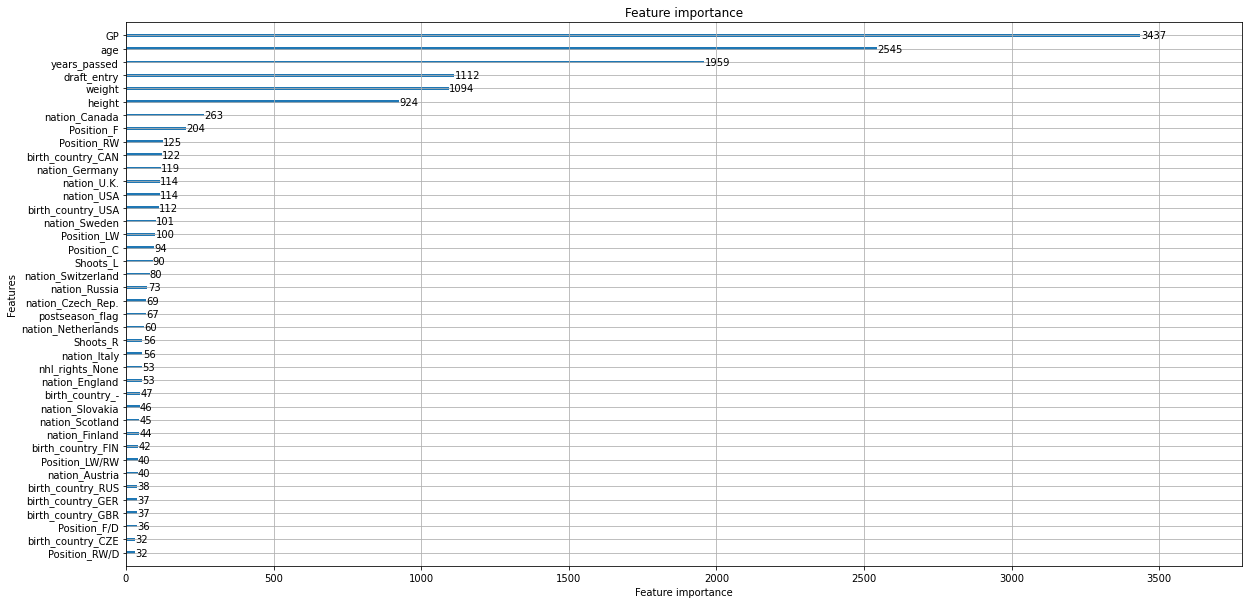

In [25]:
plot_importance(model, max_num_features=40, figsize=(20, 10))